In [ ]:
!pip install librosa soundfile numpy matplotlib tensorflow


In [1]:
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import os




In [ ]:
print(tf.__version__)  # Should return a valid version (e.g., 2.x.x)


2.18.0


In [6]:
clean_audio_path = '/content/librispeech_clean'  # Example
noisy_audio_path = '/content/795533__lastraindrop__traffic-and-crowd-on-the-overpass.wav'  # Example



In [ ]:
# Load noisy audio
noisy_audio, sr = librosa.load(noisy_audio_path, sr=None)
print("Noisy audio loaded. Duration (s):", len(noisy_audio) / sr)

# Optionally, pick a clean audio file from the clean dataset folder
import glob

# Grab the first clean WAV file (you can change the pattern as needed)
clean_audio_files = glob.glob(clean_audio_path + '/**/*.flac', recursive=True)
print("Found clean audio file:", clean_audio_files[0])

# Load clean audio
clean_audio, sr_clean = librosa.load(clean_audio_files[0], sr=sr)  # Resample to match noisy
print("Clean audio loaded. Duration (s):", len(clean_audio) / sr_clean)


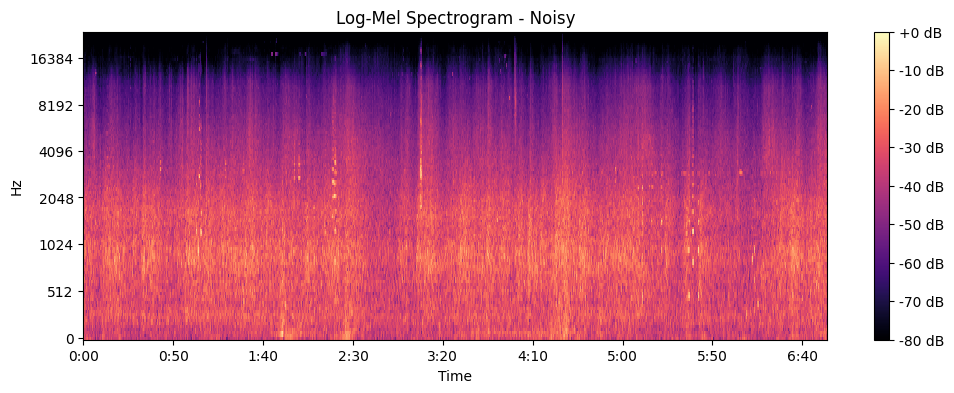

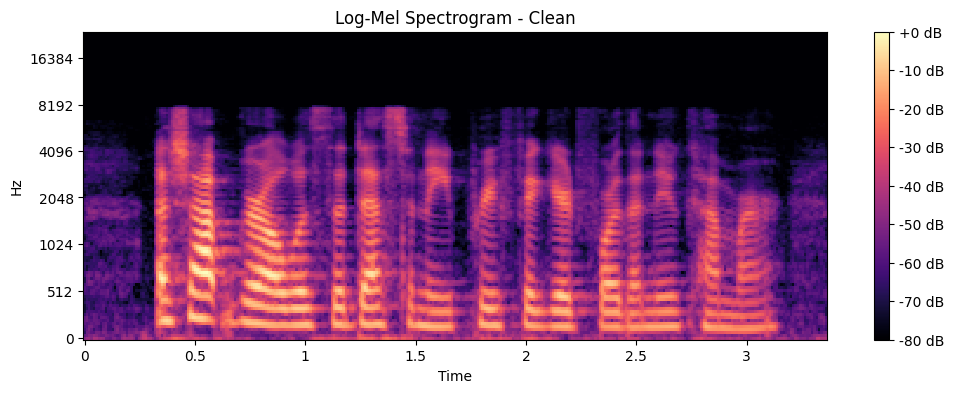

In [8]:
# Extract log-mel spectrograms
def get_log_mel(audio, sr):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    return librosa.power_to_db(mel_spec, ref=np.max)

log_mel_noisy = get_log_mel(noisy_audio, sr)
log_mel_clean = get_log_mel(clean_audio, sr)

# Visualize
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_mel_noisy, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log-Mel Spectrogram - Noisy')
plt.colorbar(format='%+2.0f dB')
plt.show()

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_mel_clean, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log-Mel Spectrogram - Clean')
plt.colorbar(format='%+2.0f dB')
plt.show()


In [11]:
from sklearn.model_selection import train_test_split

# Match the number of frames
min_frames = min(log_mel_noisy.shape[1], log_mel_clean.shape[1])

# Crop both to the same length
X = log_mel_noisy[:, :min_frames].T
y = log_mel_clean[:, :min_frames].T
# Normalize
X = X / np.max(np.abs(X))
y = y / np.max(np.abs(y))

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],)),
    Dense(128, activation='relu'),
    Dense(X.shape[1])  # Output same as input
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,432 (322.00 KB)

 Trainable params: 82,432 (322.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.5317 - val_loss: 0.2971
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2394 - val_loss: 0.1141
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0864 - val_loss: 0.0423
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0354 - val_loss: 0.0277
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0255 - val_loss: 0.0254
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0207 - val_loss: 0.0226
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0199 - val_loss: 0.0223
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0205 - val_loss: 0.0222
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0216 - val_loss: 0.0223
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0211 - val_loss: 0.0221
Epoch 12/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0214 - val_loss: 0.0223
E

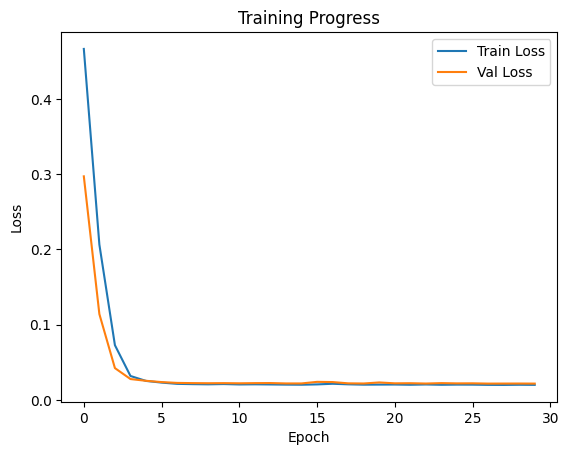

In [14]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.show()


In [17]:
# Predict on test data
denoised_output = model.predict(X_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [21]:
# Take the first prediction
denoised_log_mel = denoised_output.T
  # shape: (n_mels, time)

# Convert back to mel power
denoised_mel = librosa.db_to_power(denoised_log_mel, ref=np.max(denoised_log_mel))


# Invert to waveform using Griffin-Lim
reconstructed_audio = librosa.feature.inverse.mel_to_audio(denoised_mel, sr=sr, n_iter=32)

# Save as WAV
import soundfile as sf
sf.write('denoised_output.wav', reconstructed_audio, sr)
